# Lab3

In [45]:
import sys, subprocess
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Агрегация по дням

In [46]:
in_path = Path("household_power_consumption.csv")
out_path = Path("household_power_consumption_daily_sum.csv")

if not in_path.exists():
    raise FileNotFoundError(f"Не найден входной файл: {in_path.resolve()}")

usecols = [
    "Date","Time",
    "Global_active_power","Global_reactive_power","Voltage","Global_intensity",
    "Sub_metering_1","Sub_metering_2","Sub_metering_3",
]

df = pd.read_csv(
    in_path,
    sep=';',
    usecols=usecols,
    na_values=['?'],
    parse_dates={"DateTime": ["Date","Time"]},
    dayfirst=True,
    infer_datetime_format=True,
    low_memory=False
)

df = df.set_index("DateTime")
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors="coerce")

daily = df.resample('D').sum(numeric_only=True)
daily = daily.dropna(how='all')

daily_out = daily.copy()
daily_out.insert(0, "Date", daily_out.index.date.astype(str))

daily_out.to_csv(out_path, index=False)

print(f"Сохранено: {out_path.resolve()}\nСтрок: {len(daily_out)}, Колонок: {daily_out.shape[1]}")
daily_out.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_16636\3040510282.py:13: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(
C:\Users\Admin\AppData\Local\Temp\ipykernel_16636\3040510282.py:13: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(


Сохранено: C:\Users\Admin\Desktop\ts-smvfe\household_power_consumption_daily_sum.csv
Строк: 1442, Колонок: 8


,Date,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,,
2006-12-16,2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
2006-12-17,2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2006-12-18,2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
2006-12-19,2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
2006-12-20,2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


## Анализ и моделирование дневного ряда

Всего точек: 1442. Train: 1153, Test: 289. Граница теста: 2010-02-11


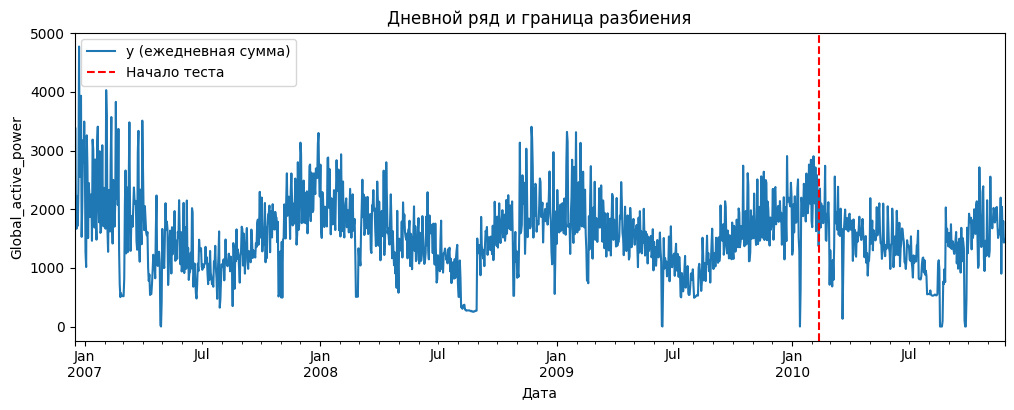

In [47]:
DAILY_PATH = Path("household_power_consumption_daily_sum.csv")
if not DAILY_PATH.exists():
    raise FileNotFoundError(f"Не найден файл с дневной агрегацией: {DAILY_PATH.resolve()}")

daily = pd.read_csv(DAILY_PATH)
daily['Date'] = pd.to_datetime(daily['Date'])
daily = daily.set_index('Date').sort_index()

y = daily['Global_active_power'].astype(float).dropna()

n = len(y)
split_idx = int(n * 0.8)
split_date = y.index[split_idx]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

print(f"Всего точек: {n}. Train: {len(y_train)}, Test: {len(y_test)}. Граница теста: {split_date.date()}")

fig, ax = plt.subplots(figsize=(12,4))
y.plot(ax=ax, label='y (ежедневная сумма)')
ax.axvline(split_date, color='red', linestyle='--', label='Начало теста')
ax.legend(); ax.set_title('Дневной ряд и граница разбиения'); ax.set_xlabel('Дата'); ax.set_ylabel('Global_active_power')
plt.show()

### Тренд и сезонность: скользящая статистика и декомпозиция
Посмотрим скользящее среднее/стандартное отклонение и выполним STL/seasonal_decompose c недельной сезонностью.

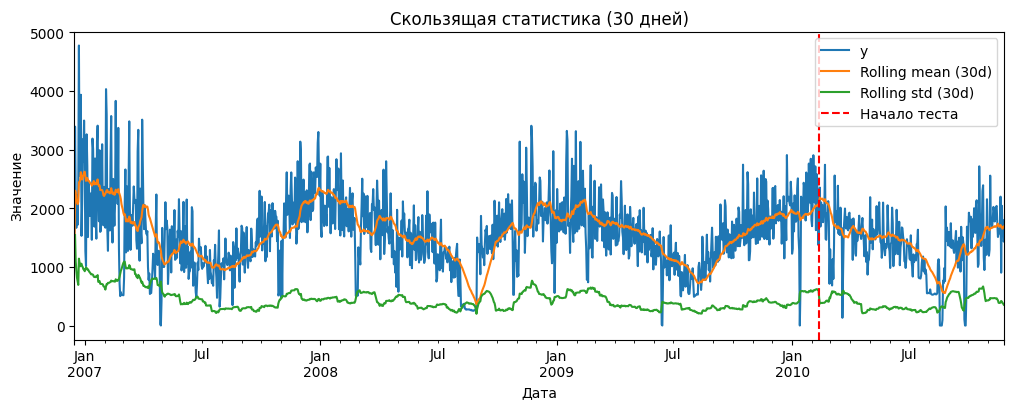

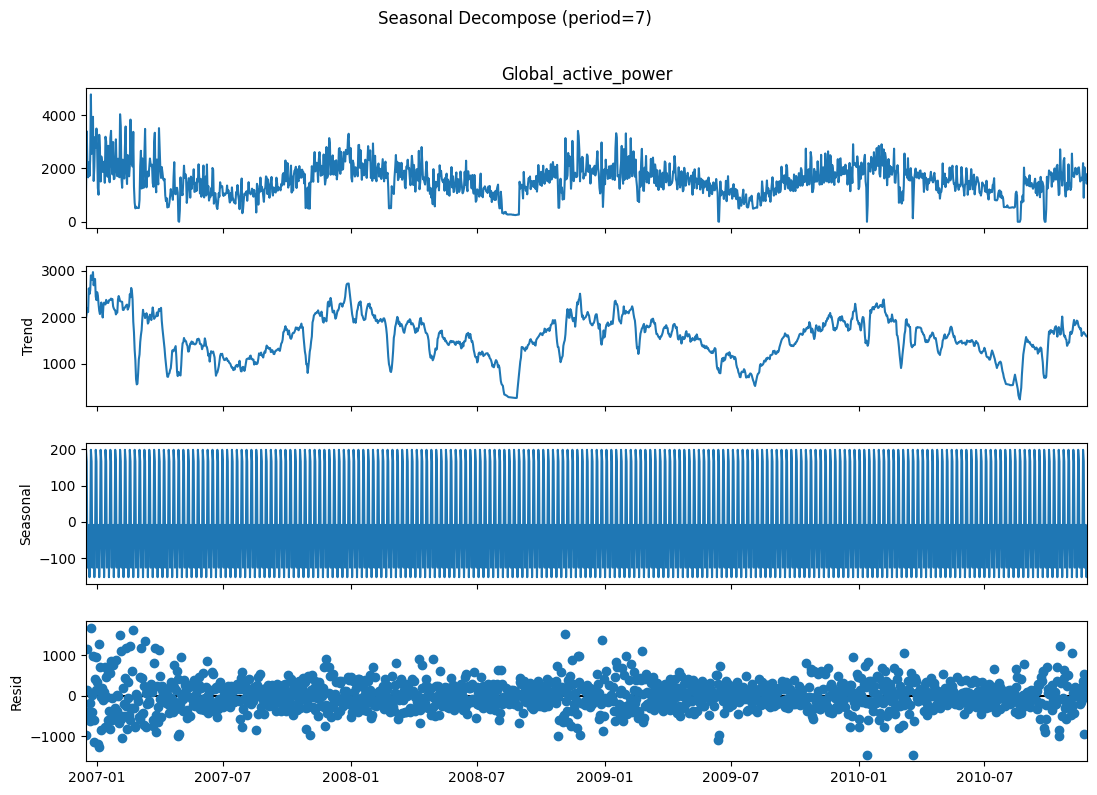

In [48]:
roll_mean_30 = y.rolling(window=30, min_periods=1).mean()
roll_std_30 = y.rolling(window=30, min_periods=1).std()

fig, ax = plt.subplots(figsize=(12,4))
y.plot(ax=ax, label='y')
roll_mean_30.plot(ax=ax, label='Rolling mean (30d)')
roll_std_30.plot(ax=ax, label='Rolling std (30d)')
ax.axvline(split_date, color='red', linestyle='--', label='Начало теста')
ax.legend(); ax.set_title('Скользящая статистика (30 дней)'); ax.set_xlabel('Дата'); ax.set_ylabel('Значение')
plt.show()

decomp = seasonal_decompose(y, model='additive', period=7, extrapolate_trend='freq')
fig = decomp.plot()
fig.set_size_inches(12, 8)
plt.suptitle('Seasonal Decompose (period=7)', y=1.02)
plt.show()

### Стационарность, логарифмирование, дифференцирование


In [49]:
def adf_report(series, name="series"):
    series = series.dropna()
    result = adfuller(series, autolag='AIC')
    stat, pvalue = result[0], result[1]
    print(f"{name}: stat = {stat:.3f}, p-value = {pvalue:.5f}")
    return pvalue

p0 = adf_report(y, 'y (raw)')

y_log = np.log1p(y)
p1 = adf_report(y_log, 'log1p(y)')

y_diff1 = y.diff(1)
p2 = adf_report(y_diff1, 'diff1(y)')

y_seasdiff = y.diff(7)
p3 = adf_report(y_seasdiff, 'diff7(y)')

y_log_diff1 = y_log.diff(1)
p4 = adf_report(y_log_diff1, 'diff1(log1p(y))')

def invert_log1p(x):
    return np.expm1(x)

def invert_diff1(last_value, diffs):
    values = [last_value]
    for d in diffs:
        values.append(values[-1] + d)
    return np.array(values[1:])

y (raw): stat = -3.850, p-value = 0.00244
log1p(y): stat = -7.220, p-value = 0.00000
diff1(y): stat = -10.911, p-value = 0.00000
diff7(y): stat = -10.823, p-value = 0.00000
diff1(log1p(y)): stat = -13.575, p-value = 0.00000
diff1(log1p(y)): stat = -13.575, p-value = 0.00000


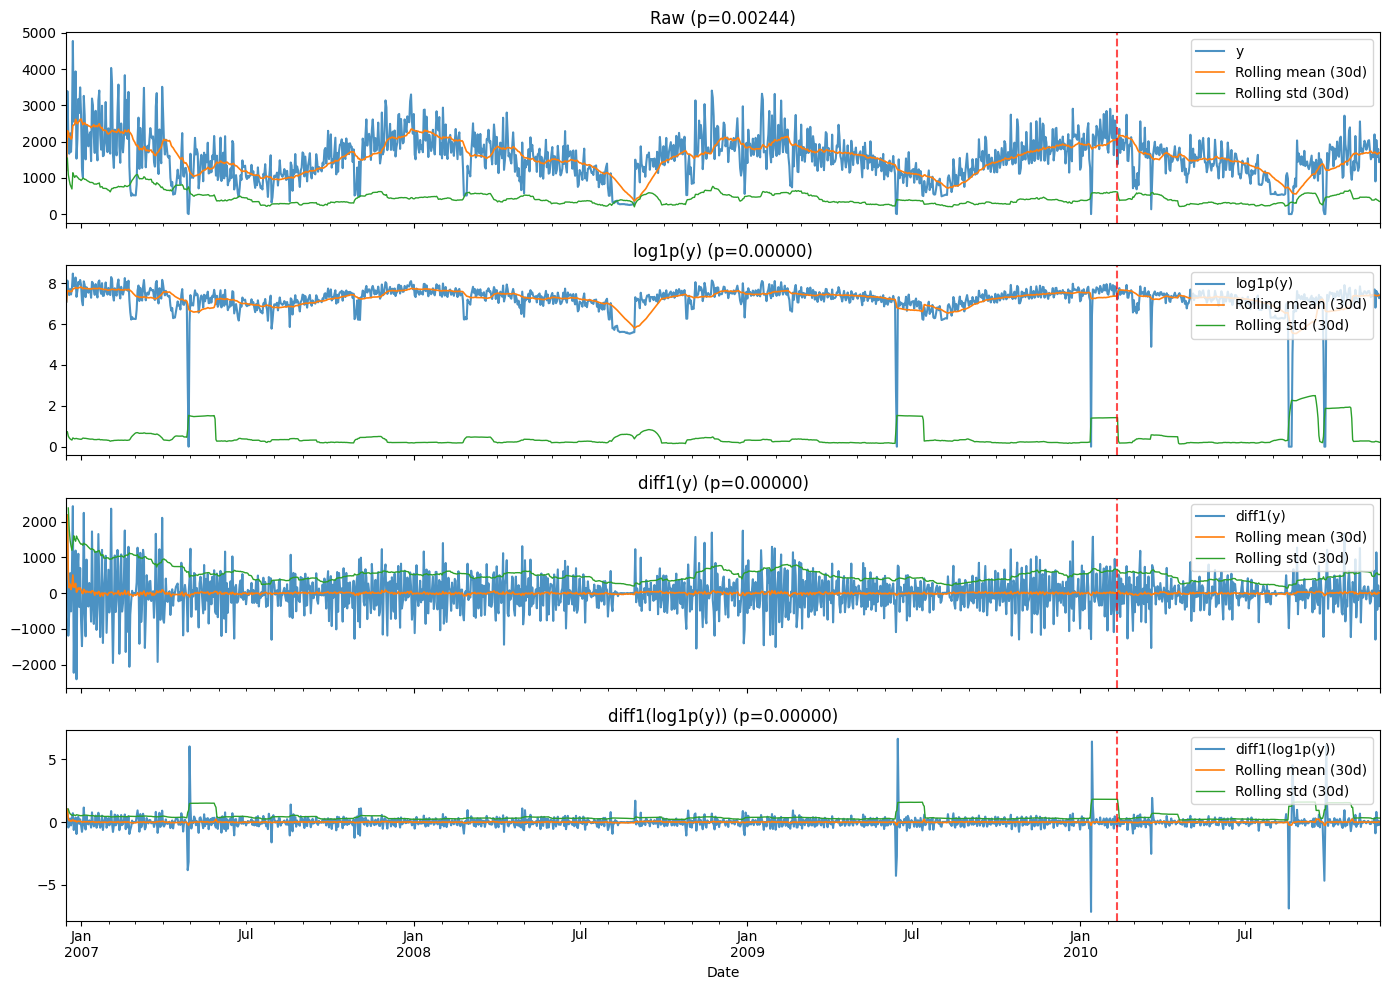

In [50]:
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
axes = axes.ravel()

rm = y.rolling(30, min_periods=1).mean()
rs = y.rolling(30, min_periods=1).std()
y.plot(ax=axes[0], color='C0', alpha=0.8, label='y')
rm.plot(ax=axes[0], color='C1', lw=1.2, label='Rolling mean (30d)')
rs.plot(ax=axes[0], color='C2', lw=1.0, label='Rolling std (30d)')
axes[0].axvline(split_date, color='red', linestyle='--', alpha=0.7)
axes[0].set_title(f"Raw (p={p0:.5f})")
axes[0].legend(loc='upper right')

rm = y_log.rolling(30, min_periods=1).mean()
rs = y_log.rolling(30, min_periods=1).std()
y_log.plot(ax=axes[1], color='C0', alpha=0.8, label='log1p(y)')
rm.plot(ax=axes[1], color='C1', lw=1.2, label='Rolling mean (30d)')
rs.plot(ax=axes[1], color='C2', lw=1.0, label='Rolling std (30d)')
axes[1].axvline(split_date, color='red', linestyle='--', alpha=0.7)
axes[1].set_title(f"log1p(y) (p={p1:.5f})")
axes[1].legend(loc='upper right')

rm = y_diff1.rolling(30, min_periods=1).mean()
rs = y_diff1.rolling(30, min_periods=1).std()
y_diff1.plot(ax=axes[2], color='C0', alpha=0.8, label='diff1(y)')
rm.plot(ax=axes[2], color='C1', lw=1.2, label='Rolling mean (30d)')
rs.plot(ax=axes[2], color='C2', lw=1.0, label='Rolling std (30d)')
axes[2].axvline(split_date, color='red', linestyle='--', alpha=0.7)
axes[2].set_title(f"diff1(y) (p={p2:.5f})")
axes[2].legend(loc='upper right')

rm = y_log_diff1.rolling(30, min_periods=1).mean()
rs = y_log_diff1.rolling(30, min_periods=1).std()
y_log_diff1.plot(ax=axes[3], color='C0', alpha=0.8, label='diff1(log1p(y))')
rm.plot(ax=axes[3], color='C1', lw=1.2, label='Rolling mean (30d)')
rs.plot(ax=axes[3], color='C2', lw=1.0, label='Rolling std (30d)')
axes[3].axvline(split_date, color='red', linestyle='--', alpha=0.7)
axes[3].set_title(f"diff1(log1p(y)) (p={p4:.5f})")
axes[3].legend(loc='upper right')

plt.tight_layout(); plt.show()

In [ ]:
transform_meta = {
    'use_log1p': True,    
    'use_diff1': False,
    'last_train_value': y_train.iloc[-1] 
}

def forward_transform(s: pd.Series, meta: dict) -> pd.Series:
    z = s.copy()
    if meta.get('use_log1p', False):
        z = np.log1p(z)
    if meta.get('use_diff1', False):
        z = z.diff(1)
    return z.dropna()

def inverse_transform(pred: pd.Series, meta: dict) -> pd.Series:
    z = pred.copy()
    if meta.get('use_diff1', False):
        last_val = meta['last_train_value']
        if meta.get('use_log1p', False):
            last_val = np.log1p(last_val)
        z = pd.Series(invert_diff1(last_val, z.values), index=pred.index)
    if meta.get('use_log1p', False):
        z = pd.Series(invert_log1p(z.values), index=pred.index)
    return z

### Признаки из метки времени и табличная регрессия

In [52]:
def build_time_features(s: pd.Series) -> pd.DataFrame:
    idx = s.index
    df_feat = pd.DataFrame(index=idx)
    df_feat['dow'] = idx.dayofweek
    df_feat['month'] = idx.month
    df_feat['dom'] = idx.day
    df_feat['doy'] = idx.dayofyear
    df_feat['week'] = idx.isocalendar().week.astype(int)

    df_feat['dow_sin'] = np.sin(2*np.pi*df_feat['dow']/7)
    df_feat['dow_cos'] = np.cos(2*np.pi*df_feat['dow']/7)
    df_feat['month_sin'] = np.sin(2*np.pi*(df_feat['month']-1)/12)
    df_feat['month_cos'] = np.cos(2*np.pi*(df_feat['month']-1)/12)
    df_feat['doy_sin'] = np.sin(2*np.pi*(df_feat['doy']-1)/365)
    df_feat['doy_cos'] = np.cos(2*np.pi*(df_feat['doy']-1)/365)

    return df_feat


def add_lags(s: pd.Series, lags=(1,7,14)) -> pd.DataFrame:
    df_lag = pd.DataFrame(index=s.index)
    for L in lags:
        df_lag[f'lag_{L}'] = s.shift(L)
    return df_lag


def regression_dataset(y_series: pd.Series, lags=(1,7,14)):
    X = build_time_features(y_series)
    X = X.join(add_lags(y_series, lags=lags))
    y_out = y_series
    data = X.join(y_out.rename('target')).dropna()
    return data.drop(columns=['target']), data['target']

USE_LOG_TARGET = True  

X, y_full = regression_dataset(y, lags=(1,7,14))
X_train, y_rf_train = X.loc[y_train.index.intersection(X.index)], y_full.loc[y_train.index.intersection(X.index)]
X_test, y_rf_test = X.loc[y_test.index.intersection(X.index)], y_full.loc[y_test.index.intersection(X.index)]

rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)

if USE_LOG_TARGET:
    y_train_t = np.log1p(y_rf_train)
    rf.fit(X_train, y_train_t)
    rf_pred_train_t = pd.Series(rf.predict(X_train), index=X_train.index)
    rf_pred_test_t = pd.Series(rf.predict(X_test), index=X_test.index)
    rf_pred_train = pd.Series(np.expm1(rf_pred_train_t.values), index=rf_pred_train_t.index)
    rf_pred_test = pd.Series(np.expm1(rf_pred_test_t.values), index=rf_pred_test_t.index)
else:
    rf.fit(X_train, y_rf_train)
    rf_pred_train = pd.Series(rf.predict(X_train), index=X_train.index)
    rf_pred_test = pd.Series(rf.predict(X_test), index=X_test.index)

rf_mae = mean_absolute_error(y_rf_test, rf_pred_test)
rf_rmse = mean_squared_error(y_rf_test, rf_pred_test) ** 0.5
print(f"RandomForest ({'log-target' if USE_LOG_TARGET else 'raw-target'}) - Test MAE: {rf_mae:.2f}, RMSE: {rf_rmse:.2f}")

RandomForest (log-target) - Test MAE: 257.35, RMSE: 363.44


Сводка по признакам:
Всего признаков          14
Календарные               5
Циклические (sin/cos)     6
Лаги                      3
dtype: int64

Первые строки X_train:
            dow  month  dom  doy  week   dow_sin   dow_cos  month_sin  \
Date                                                                    
2006-12-30    5     12   30  364    52 -0.974928 -0.222521       -0.5   
2006-12-31    6     12   31  365    52 -0.781831  0.623490       -0.5   
2007-01-01    0      1    1    1     1  0.000000  1.000000        0.0   

            month_cos   doy_sin   doy_cos     lag_1     lag_7    lag_14  
Date                                                                     
2006-12-30   0.866025 -0.034422  0.999407  3174.392  4773.386  1209.176  
2006-12-31   0.866025 -0.017213  0.999852  2789.302  2550.012  3390.460  
2007-01-01   1.000000  0.000000  1.000000  3494.196  2743.120  2203.826  

Топ-15 признаков по важности:
      feature  importance
11      lag_1    0.486771
10    doy_c

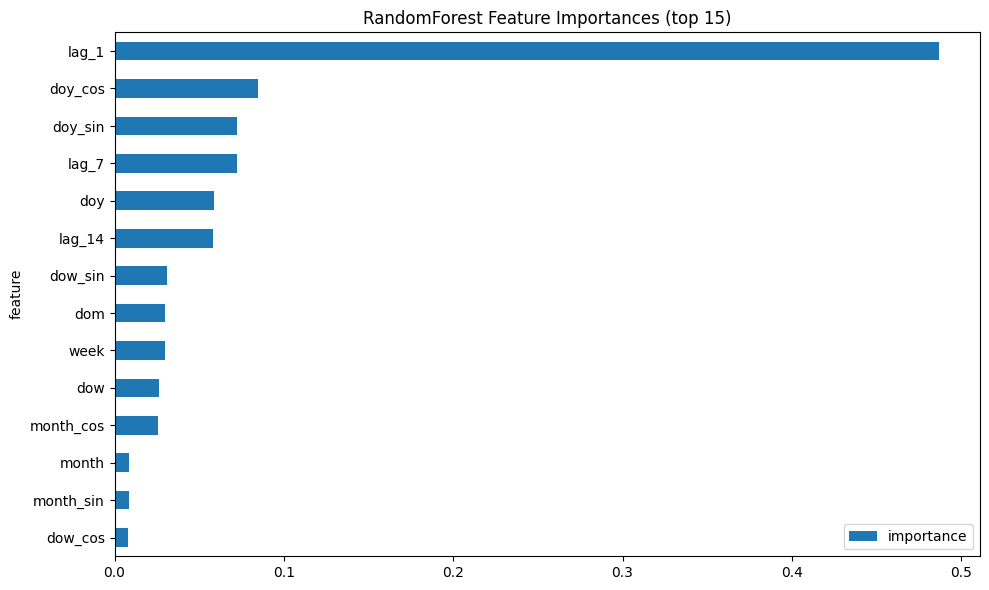


RandomForest — Test MAE: 257.35, RMSE: 363.44


In [53]:
feature_cols = list(X.columns)
cal_cols = ['dow','month','dom','doy','week']
cyc_cols = ['dow_sin','dow_cos','month_sin','month_cos','doy_sin','doy_cos']
lag_cols = [c for c in feature_cols if c.startswith('lag_')]

summary = pd.Series({
    'Всего признаков': len(feature_cols),
    'Календарные': len([c for c in feature_cols if c in cal_cols]),
    'Циклические (sin/cos)': len([c for c in feature_cols if c in cyc_cols]),
    'Лаги': len(lag_cols)
})
print('Сводка по признакам:')
print(summary)
print('\nПервые строки X_train:')
print(X_train.head(3))

if hasattr(rf, 'feature_importances_'):
    imp = pd.DataFrame({
        'feature': feature_cols,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    topn = 15
    print(f"\nТоп-{topn} признаков по важности:")
    print(imp.head(topn))
    
    fig, ax = plt.subplots(figsize=(10,6))
    imp.head(topn).iloc[::-1].plot(kind='barh', x='feature', y='importance', ax=ax)
    ax.set_title('RandomForest Feature Importances (top 15)')
    plt.tight_layout(); plt.show()
else:
    print('Модель не предоставляет feature_importances_.')

print(f"\nRandomForest — Test MAE: {rf_mae:.2f}, RMSE: {rf_rmse:.2f}")

### Наивная модель
Предсказывает константой — средним значением на тренировке.

In [54]:
naive_value = y_train.mean()
naive_pred_test = pd.Series(naive_value, index=y_test.index)
naive_mae = mean_absolute_error(y_test, naive_pred_test)
naive_rmse = mean_squared_error(y_test, naive_pred_test) ** 0.5
print(f"Naive-Mean - Test MAE: {naive_mae:.2f}, RMSE: {naive_rmse:.2f}")

naive_pred_train = pd.Series(naive_value, index=y_train.index)

Naive-Mean - Test MAE: 400.87, RMSE: 536.03


### Хольт-Уинтерс

In [ ]:
seasonal_period = 7

window_candidates = sorted({
    len(y_train),
    min(len(y_train), 730),
    min(len(y_train), 365)
})
window_candidates = [w for w in window_candidates if w > seasonal_period + 5]

trend_options = [None, 'add']
seasonal_options = [None, 'add']
damped_options = [False, True]
boxcox_options = [None, 'log']

results = []
eps = 1e-3

for window_size in window_candidates:
    series_full = y_train.iloc[-window_size:]
    series_model = series_full.clip(lower=eps)

    val_len = max(seasonal_period * 2, int(window_size * 0.2))
    val_len = min(val_len, window_size - (seasonal_period + 2))
    if val_len <= 0:
        continue

    hw_train = series_model.iloc[:-val_len]
    hw_val_target = series_full.iloc[-val_len:]

    for trend in trend_options:
        for seasonal in seasonal_options:
            seasonal_periods = seasonal_period if seasonal else None

            for damped in damped_options:
                if trend is None and damped:
                    continue

                for boxcox in boxcox_options:
                    if boxcox == 'log' and (hw_train <= 0).any():
                        continue

                    try:
                        with warnings.catch_warnings():
                            warnings.simplefilter("ignore")
                            model = ExponentialSmoothing(
                                hw_train,
                                trend=trend,
                                damped_trend=damped if trend else False,
                                seasonal=seasonal,
                                seasonal_periods=seasonal_periods,
                                initialization_method='estimated'
                            )
                            fit_kwargs = {'optimized': True, 'remove_bias': True}
                            if boxcox is not None:
                                fit_kwargs['use_boxcox'] = boxcox
                            fitted = model.fit(**fit_kwargs)
                        val_forecast = fitted.forecast(steps=val_len)
                        val_rmse = mean_squared_error(hw_val_target, val_forecast) ** 0.5
                        results.append({
                            'window_size': window_size,
                            'trend': trend,
                            'seasonal': seasonal,
                            'damped': damped if trend else False,
                            'boxcox': boxcox,
                            'val_rmse': val_rmse
                        })
                    except Exception:
                        continue

if not results:
    raise RuntimeError("Holt-Winters search failed; no configurations converged.")

best_cfg = min(results, key=lambda x: x['val_rmse'])
print(
    "Лучший Holt-Винтерс по RMSE на валидации: window={window_size}, trend={trend}, seasonal={seasonal}, "
    "damped={damped}, boxcox={boxcox}, val_RMSE={val_rmse:.2f}".format(**best_cfg)
)

fit_series_full = y_train.iloc[-best_cfg['window_size']:]
fit_series_model = fit_series_full.clip(lower=eps)

fit_kwargs = {'optimized': True, 'remove_bias': True}
if best_cfg['boxcox'] is not None:
    fit_kwargs['use_boxcox'] = best_cfg['boxcox']

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    holt_winters_model = ExponentialSmoothing(
        fit_series_model,
        trend=best_cfg['trend'],
        damped_trend=best_cfg['damped'],
        seasonal=best_cfg['seasonal'],
        seasonal_periods=seasonal_period if best_cfg['seasonal'] else None,
        initialization_method='estimated'
    ).fit(**fit_kwargs)

partial_fitted = pd.Series(holt_winters_model.fittedvalues, index=fit_series_full.index)
holt_winters_fitted_train = pd.Series(np.nan, index=y_train.index)
holt_winters_fitted_train.loc[partial_fitted.index] = partial_fitted

rolling_series_model = fit_series_model.copy()
rolling_series_full = fit_series_full.copy()
preds = []

for timestamp, actual in y_test.items():
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        step_model = ExponentialSmoothing(
            rolling_series_model,
            trend=best_cfg['trend'],
            damped_trend=best_cfg['damped'],
            seasonal=best_cfg['seasonal'],
            seasonal_periods=seasonal_period if best_cfg['seasonal'] else None,
            initialization_method='estimated'
        ).fit(**fit_kwargs)
    forecast_value = step_model.forecast(steps=1)[0]
    preds.append(forecast_value)

    rolling_series_full = pd.concat([
        rolling_series_full,
        pd.Series([actual], index=[timestamp])
    ])
    rolling_series_model = pd.concat([
        rolling_series_model,
        pd.Series([max(actual, eps)], index=[timestamp])
    ])
    if len(rolling_series_model) > best_cfg['window_size']:
        rolling_series_model = rolling_series_model.iloc[-best_cfg['window_size']:]
        rolling_series_full = rolling_series_full.iloc[-best_cfg['window_size']:]

holt_winters_pred_test = pd.Series(preds, index=y_test.index)

holt_winters_mae = mean_absolute_error(y_test, holt_winters_pred_test)
holt_winters_rmse = mean_squared_error(y_test, holt_winters_pred_test) ** 0.5
print(f"Holt-Winters (подбор по валидации) - Test MAE: {holt_winters_mae:.2f}, RMSE: {holt_winters_rmse:.2f}")

### SARIMA

In [56]:
seasonal_period = 7

X_exog_all = build_time_features(y)[['dow_sin', 'dow_cos']]
X_exog_tr = X_exog_all.loc[y_train.index]
X_exog_te = X_exog_all.loc[y_test.index]

y_train_log = np.log1p(y_train)

candidates = [
    ((1, 1, 1), (0, 1, 1, seasonal_period)),
    ((0, 1, 1), (0, 1, 1, seasonal_period)),
    ((1, 1, 0), (0, 1, 1, seasonal_period)),
    ((1, 1, 1), (1, 1, 0, seasonal_period)),
]

sar_best_aic = np.inf
sar_best_cfg = None
sar_best_res = None
used_exog = True

for order, seasonal_order in candidates:
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            m = SARIMAX(
                y_train_log,
                exog=X_exog_tr,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=True,
                enforce_invertibility=True,
                trend='n'
            )
            r = m.fit(disp=False, method='lbfgs', maxiter=100)
        if np.isfinite(r.aic) and r.aic < sar_best_aic:
            sar_best_aic = r.aic
            sar_best_cfg = (order, seasonal_order)
            sar_best_res = r
    except Exception:
        continue

if sar_best_res is None:
    used_exog = False
    sar_best_cfg = ((1, 1, 1), (0, 1, 1, seasonal_period))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sar_best_res = SARIMAX(
            y_train_log,
            order=sar_best_cfg[0],
            seasonal_order=sar_best_cfg[1],
            enforce_stationarity=True,
            enforce_invertibility=True,
            trend='n'
        ).fit(disp=False, method='lbfgs', maxiter=100)
    sar_best_aic = sar_best_res.aic

order, sorder = sar_best_cfg
print(f"Лучший SARIMAX по AIC (log-scale): order={order}, seasonal_order={sorder}, exog={'yes' if used_exog else 'no'}, AIC={sar_best_aic:.2f}")

sar_window_size = min(len(y_train), 365)
if sar_window_size <= seasonal_period + 5:
    sar_window_size = min(len(y_train), 730)
if sar_window_size <= seasonal_period + 5:
    sar_window_size = len(y_train)
print(f"SARIMAX rolling window size: {sar_window_size}")

fit_index = y_train.index[-sar_window_size:]
y_fit = y_train.loc[fit_index]
y_fit_log = np.log1p(y_fit)
X_fit = X_exog_tr.loc[fit_index] if used_exog else None

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    r_fit = SARIMAX(
        y_fit_log,
        exog=X_fit,
        order=order,
        seasonal_order=sorder,
        enforce_stationarity=True,
        enforce_invertibility=True,
        trend='n'
    ).fit(disp=False, method='lbfgs', maxiter=80)

fitted_log = r_fit.predict(start=fit_index[0], end=fit_index[-1], exog=X_fit if used_exog else None)
sarima_fitted_train = pd.Series(np.nan, index=y_train.index)
sarima_fitted_train.loc[fit_index] = np.expm1(fitted_log).values


def _append_results(res, endog_new, exog_new):
    if hasattr(res, 'append'):
        return res.append(endog=endog_new, exog=exog_new, refit=False)
    if hasattr(res, 'extend'):
        return res.extend(endog=endog_new, exog=exog_new, refit=False)
    raise AttributeError('Statsmodels results object lacks append/extend methods.')

res_roll = r_fit
preds = []
_endog_name = y_fit_log.name if hasattr(y_fit_log, 'name') else None
for ts, actual in y_test.items():
    exog_next = X_exog_te.loc[[ts]] if used_exog else None
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        fc = res_roll.get_forecast(steps=1, exog=exog_next)
    fcst_log = float(np.asarray(fc.predicted_mean)[0])
    preds.append(np.expm1(fcst_log))

    endog_new = pd.Series([np.log1p(actual)], index=[ts], name=_endog_name)
    res_roll = _append_results(res_roll, endog_new, exog_next)

sarima_pred_test = pd.Series(preds, index=y_test.index)

sarima_mae = mean_absolute_error(y_test, sarima_pred_test)
sarima_rmse = mean_squared_error(y_test, sarima_pred_test) ** 0.5
print(f"SARIMAX- Test MAE: {sarima_mae:.2f}, RMSE: {sarima_rmse:.2f}")

Лучший SARIMAX по AIC (log-scale): order=(1, 1, 1), seasonal_order=(0, 1, 1, 7), exog=yes, AIC=1638.29
SARIMAX rolling window size: 365
SARIMAX- Test MAE: 354.55, RMSE: 480.00
SARIMAX- Test MAE: 354.55, RMSE: 480.00


### Сводная визуализация и метрики


Метрики на тесте:
          model         MAE        RMSE
3            RF  257.348370  363.440084
1  Holt-Winters  282.702083  397.660404
2        SARIMA  354.546974  480.004003
0         Naive  400.873934  536.032501


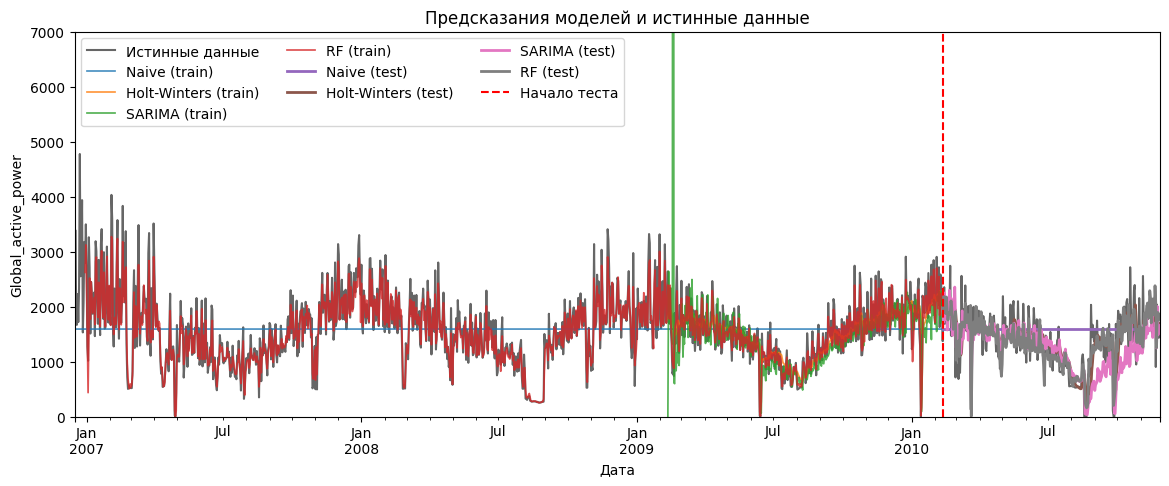

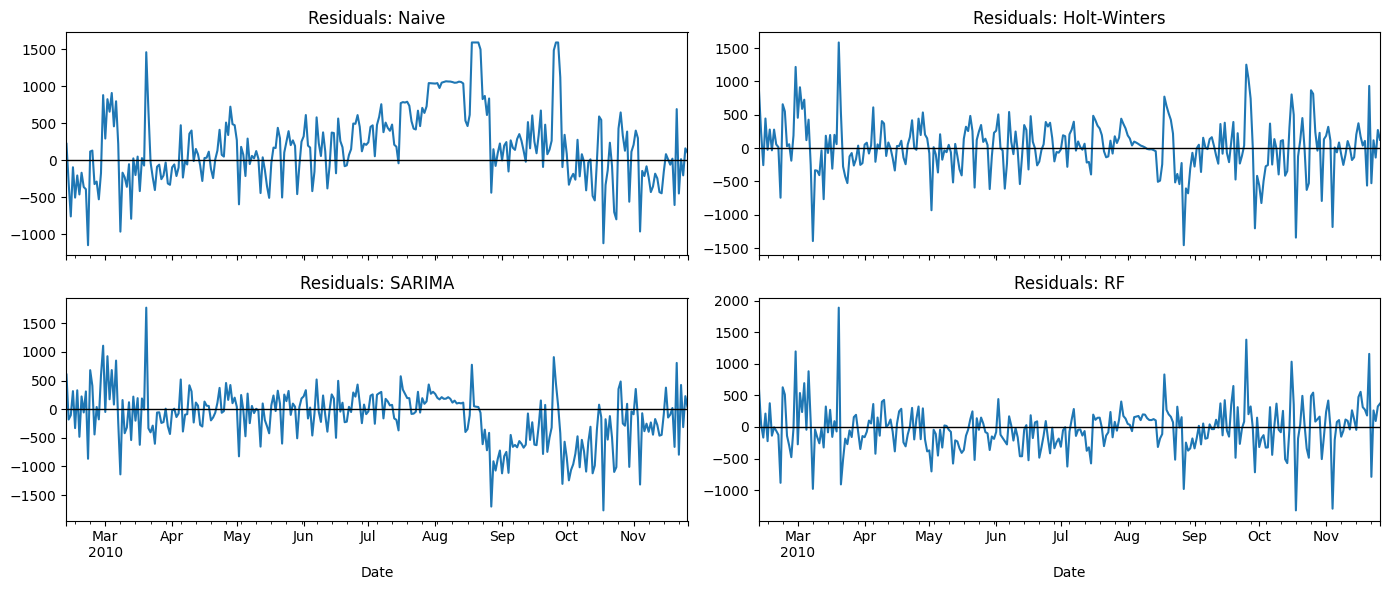

In [57]:
pred_train = pd.DataFrame({
    'Naive': naive_pred_train,
    'Holt-Winters': holt_winters_fitted_train.reindex(y_train.index),
    'SARIMA': sarima_fitted_train.reindex(y_train.index) if 'sarima_fitted_train' in globals() else pd.Series(index=y_train.index, dtype=float),
    'RF': rf_pred_train.reindex(y_train.index)
}, index=y_train.index)

pred_test = pd.DataFrame({
    'Naive': naive_pred_test,
    'Holt-Winters': holt_winters_pred_test,
    'SARIMA': sarima_pred_test if 'sarima_pred_test' in globals() else pd.Series(index=y_test.index, dtype=float),
    'RF': rf_pred_test.reindex(y_test.index)
}, index=y_test.index)

metrics = []
for name in pred_test.columns:
    mae = mean_absolute_error(y_test, pred_test[name])
    rmse = mean_squared_error(y_test, pred_test[name]) ** 0.5
    metrics.append({'model': name, 'MAE': mae, 'RMSE': rmse})
metrics_df = pd.DataFrame(metrics).sort_values('RMSE')
print("\nМетрики на тесте:")
print(metrics_df)

series_for_scale = [y]
series_for_scale += [pred_train[c] for c in pred_train.columns]
series_for_scale += [pred_test[c] for c in pred_test.columns]
combined_vals = pd.concat(series_for_scale, axis=0).astype(float)
low_q = combined_vals.quantile(0.005)
ymin = 0.0 if combined_vals.min() >= 0 else float(low_q)
ymax = 7000.0

fig, ax = plt.subplots(figsize=(14,5))
y.plot(ax=ax, label='Истинные данные', color='black', alpha=0.6)
for name, series in pred_train.items():
    series.plot(ax=ax, alpha=0.8, lw=1.25, label=f'{name} (train)')
for name, series in pred_test.items():
    series.plot(ax=ax, lw=2, label=f'{name} (test)')
ax.set_ylim(ymin, ymax)
ax.axvline(split_date, color='red', linestyle='--', label='Начало теста')
ax.set_title('Предсказания моделей и истинные данные')
ax.set_xlabel('Дата'); ax.set_ylabel('Global_active_power')
ax.legend(ncol=3)
plt.show()

residuals = pred_test.subtract(y_test, axis=0)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,6), sharex=True)
axes = axes.ravel()
for i, name in enumerate(pred_test.columns):
    residuals[name].plot(ax=axes[i], title=f'Residuals: {name}')
    axes[i].axhline(0, color='black', lw=1)

for j in range(len(pred_test.columns), 4):
    axes[j].axis('off')
plt.tight_layout(); plt.show()